## Imports

In [53]:
from sklearn.model_selection import train_test_split , ShuffleSplit
from sklearn.metrics import mean_squared_error, confusion_matrix, ConfusionMatrixDisplay
from sklearn import metrics
import xgboost as xgb
from xgboost import plot_importance

import pandas as pd
import numpy as np
import random

import backtrader as bt

import matplotlib.pyplot as plt

import tabulate

# Utils Methods & Constants

In [77]:
short_value = -1
long_value = 0
test_size = 0.4

def classifier(x):
    if( x >= 0 ):
        return long_value
    else:
        return short_value

# Method to find nearest date to a given pivot
def nearest(items, pivot):
    return min(items, key=lambda x: abs(x - pivot))

## Data loading from CSV
### Stockdata
* Load data from CSV

In [55]:
stock_list = pd.read_csv('csv/result_table_2_2.csv',sep=',')
u_symbol = stock_list['SYMBOL'].unique()
date = pd.Series(stock_list['Date'])
stock_list.drop(['Date'],axis=1,inplace=True)
stock_list['date'] = date.apply(lambda x: np.datetime64(x))

stock_list

,SYMBOL,1Month,3Months,6Months,1Year,2Years,Week1Prior,Week2Prior,Week3Prior,Month1Prior,Month2Prior,Month3Prior,Month4Prior,Month5Prior,Month6Prior,Month7Prior,Year1Prior,Year2Prior,date
0,HUBS,-0.366415,-0.312652,-0.513348,-0.583363,-0.140889,0.037376,-0.086529,-0.149574,-0.103919,-0.162219,-0.078045,-0.014958,0.129480,0.147393,0.353601,0.642656,3.278922,2021-12-23
1,MMAT,-0.293729,-0.442244,-0.495050,-0.547855,-0.976898,-0.111437,-0.098214,-0.266344,-0.364780,-0.392786,-0.407045,0.041237,-0.134286,-0.747078,-0.275120,1.705357,1.104167,2021-12-15
2,CEI,0.450549,0.000000,-0.098901,-0.747253,-0.993626,-0.733918,-0.376712,-0.445122,-0.061856,0.978261,0.654545,0.300000,0.421875,-0.061856,-0.294574,0.281690,-0.878667,2021-10-06
3,SPCE,0.294898,-0.300086,-0.577976,-0.800519,-0.880081,0.201177,0.290071,1.084736,0.768995,0.188014,0.148675,-0.383289,0.375496,0.026331,0.696333,1.006362,2.361434,2021-06-07
4,PLUG,-0.122468,-0.573873,-0.570890,-0.669336,-0.750353,-0.042831,0.346796,0.878207,0.784533,1.370301,3.237525,4.272351,4.161264,6.466589,7.665306,14.725926,46.887218,2021-01-21
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
249,CCRC,-0.033038,-0.140210,-0.103143,-0.157937,-0.629331,0.251008,0.016380,0.090510,0.035893,0.321619,0.453162,0.411832,-0.376068,-0.328100,-0.250151,-0.108477,-0.119233,2018-11-15
250,SRNEQ,0.369565,0.543478,-0.032609,0.039130,-0.606522,-0.432099,-0.402597,-0.347518,-0.480226,-0.406452,0.260274,1.044444,0.769231,1.628571,1.555556,0.150000,-0.065041,2018-03-28
251,MARK,0.350610,-0.076220,-0.376524,-0.696646,-0.914634,-0.320207,-0.441702,-0.495385,-0.497318,-0.257919,0.935103,1.122977,0.912536,1.385455,1.095847,1.030960,0.623762,2018-02-07
252,IPO.L,-0.065756,-0.294122,-0.108625,-0.241517,-0.507230,-0.004845,-0.051220,0.031400,0.039580,0.010499,0.151426,0.087297,0.004892,0.078351,0.010499,-0.076123,-0.324780,2017-12-18


In [56]:
non_test_variables = ['SYMBOL','1Month','3Months','6Months','1Year','2Years','date']
predict_variables = ['1Month','3Months','6Months','1Year','2Years']

print("Number of rows before elimination of NaN: {0}".format(len(stock_list)))
stock_list_2y = stock_list.dropna(subset=["2Years"])
print("Number of rows after elimination of NaN only in 2Years: {0}".format(len(stock_list_2y)))
stock_list_2y = stock_list_2y.dropna(subset=non_test_variables)
print("Number of rows after elimination of NaN only in 2Years and other: {0}".format(len(stock_list_2y)))
stock_list_dropna = stock_list.dropna()
print("Number of rows after elimination of NaN: {0}".format(len(stock_list_dropna)))

Number of rows before elimination of NaN: 254
Number of rows after elimination of NaN only in 2Years: 254
Number of rows after elimination of NaN only in 2Years and other: 254
Number of rows after elimination of NaN: 254


## Create Testsplit
* We create a testsplit at a certain date which allows for roughly 70% of the data to be before it for training.
* We sort the data before hand and then split it such is guranteed that we dont have future data in our training data. 
* The other 30% will be after the date, we ensure this way that when we do out of sample testing that the training wasnt
"poisoned" with future data.

In [57]:
# We dont shuffle the array to prevent having future data in training set. 
sorted_stock_list = stock_list_dropna.sort_values(['date'], ascending= True)
train, test = train_test_split(sorted_stock_list, test_size=test_size, shuffle = False)
# Making sure we got no overlap
print("First date of \033[92mtraining\033[0m data: {0}".format(train['date'].iloc[0]))
print("Last date of \033[92mtraining\033[0m data:  {0}".format(train['date'].iloc[-1]))
print("First date of \x1b[31mtest\x1b[0m data:     {0}".format(test['date'].iloc[0]))
print("Last date of \x1b[31mtest\x1b[0m data:      {0}".format(test['date'].iloc[-1]))

First date of training data: 2013-03-06 00:00:00
Last date of training data:  2019-09-18 00:00:00
First date of test data:     2019-09-26 00:00:00
Last date of test data:      2021-12-23 00:00:00


In [58]:
x_train = np.array(train.drop(non_test_variables,axis=1))
y_train = {}
for variable in predict_variables:
    y_train[variable] = np.array(train[variable])

x_test = np.array(test.drop(non_test_variables,axis=1))
y_test ={}
for variable in predict_variables:
    y_test[variable] = np.array(test[variable])

## Train

In [59]:
regressors = {}
for variable in predict_variables: 
    # Define classifier
    clf = xgb.XGBRegressor()
    # Train on trainsplit
    clf.fit(x_train,y_train[variable])
    regressors[variable] = clf

## Predict In and Out-sample

In [60]:
# predict insample
for variable in predict_variables: 
    y_pred_insample = regressors[variable].predict(x_train)
    mse = mean_squared_error(y_pred_insample, y_train[variable])
    print("Mean squared error insample for variable:{0} = {1}".format(variable, mse))

print('\n')

# predict outsample
outsample_predictions = {}
for variable in predict_variables: 
    y_pred_outsample = regressors[variable].predict(x_test)
    y_base_truth = y_test[variable]
    outsample_predictions[variable] = y_pred_outsample
    mse = mean_squared_error(y_pred_outsample, y_test[variable])
    print("Mean squared error outsample for variable:{0} = {1}".format(variable, mse))
#%TODO strategie und plot fixen
#%TODO Strategie auf dem schreiben und testen

Mean squared error insample for variable:1Month = 6.136987551443118e-07
Mean squared error insample for variable:3Months = 5.823284559780891e-07
Mean squared error insample for variable:6Months = 4.953125782481326e-07
Mean squared error insample for variable:1Year = 4.849709398016863e-07
Mean squared error insample for variable:2Years = 6.621275497959597e-07


Mean squared error outsample for variable:1Month = 0.15337933753473001
Mean squared error outsample for variable:3Months = 0.6785224731969626
Mean squared error outsample for variable:6Months = 1.0591917279040717
Mean squared error outsample for variable:1Year = 2.447906265059303
Mean squared error outsample for variable:2Years = 1.7479060300681466


## Predict direction
* We are testing if even tho the MSE isn't that great, we can at least predict the direction accuratly
* 1 represents falling 0 is rising

In [61]:
for variable in predict_variables: 
    classified_predictions = np.array(list(map(classifier, outsample_predictions[variable])))
    classified_y = np.array(list(map(classifier, y_test[variable])))
    print("Accuracy for {0} :".format(variable),metrics.accuracy_score(classified_y,classified_predictions))
    print("Precision for {0} :".format(variable),metrics.precision_score(classified_y, classified_predictions,average="macro"))
    print("Recall for {0} :".format(variable),metrics.recall_score(classified_y, classified_predictions,average="macro"))

# TODO check if 1year and 2year predictions are equally accurate for one stock

Accuracy for 1Month : 0.45098039215686275
Precision for 1Month : 0.45098039215686275
Recall for 1Month : 0.45098039215686275
Accuracy for 3Months : 0.47058823529411764
Precision for 3Months : 0.470542934154794
Recall for 3Months : 0.47058823529411764
Accuracy for 6Months : 0.5490196078431373
Precision for 6Months : 0.5397546569741027
Recall for 6Months : 0.5338491295938105
Accuracy for 1Year : 0.5588235294117647
Precision for 1Year : 0.5670760510155881
Recall for 1Year : 0.5546153846153846
Accuracy for 2Years : 0.6372549019607843
Precision for 2Years : 0.6191770186335404
Recall for 2Years : 0.6394820536119945


## Calculate possible returns
* Assuming we enter the market 1 Day after the short selling repport and either short or go long depending on the predictions over two years. 

In [62]:
# Data for the broker
clean_data = pd.read_csv('csv/clean_data_new.csv',sep=',')
u_symbol = clean_data['symbol'].unique()
date = pd.Series(clean_data['datetime'])
clean_data.drop(['datetime'],axis=1,inplace=True)
clean_data['date'] = date.apply(lambda x: np.datetime64(x))

stock_data = {}
for symbol in u_symbol:
    stock_data[symbol] = clean_data[clean_data['symbol'] == symbol]

stock_data[list(stock_data.keys())[0]]

,open,high,low,close,volume,symbol,log_returns,date
0,32.30,33.58,32.30,32.84,7315000.0,1179.HK,0.056371,2020-09-23
1,34.08,34.20,33.50,33.73,2797160.0,1179.HK,0.026740,2020-09-24
2,33.12,33.12,32.30,32.62,3964430.0,1179.HK,-0.033462,2020-09-25
3,32.68,33.22,32.68,33.08,763500.0,1179.HK,0.014003,2020-09-28
4,33.58,34.18,33.58,33.99,2398130.0,1179.HK,0.027137,2020-09-29
...,...,...,...,...,...,...,...,...
838,29.20,29.20,28.30,28.85,2695218.0,1179.HK,-0.012059,2024-02-22
839,29.10,30.05,29.10,29.70,1548300.0,1179.HK,0.029037,2024-02-23
840,30.35,31.00,30.30,30.40,3111600.0,1179.HK,0.023296,2024-02-26
841,29.60,30.10,29.15,29.95,2316600.0,1179.HK,-0.014913,2024-02-27


# Trade simulation with short and long
* Trade function takes a dataset and a regressor and then simulates a simple trading strategy
* Trading strategy consists of:
    * If the regressor predicts a rise it will go long over the period
    * If the regressor predicts a fall it will go short over the period

In [89]:
def trade_long_and_short(test, regressor = regressors['2Years'], rnd=False):
    returns = {}
    for index, row in test.iterrows():
        prediction = 0
        if(rnd):
            prediction = random.randint(-1,1)
        else:
            x = np.array(test[test['SYMBOL'] == row['SYMBOL']].drop(non_test_variables, axis=1))
            prediction = classifier(regressor.predict(x)[0])
        # print(f"prediction 2 Years for stock{row['SYMBOL']} : {prediction_2y}")

        df = stock_data[row['SYMBOL']]

        # Get the first date after short selling report
        entry_date = row['date']
        entry_pivot = nearest(np.array(df['date']),entry_date)
        entry_data = df[df['date'] == entry_pivot]
        entry_price = (entry_data['high'].values[0] + entry_data['low'].values[0])/2

        exit_date = row['date'] + np.timedelta64(730,'D')
        # Get the first date 2 years after entring the market
        exit_pivot = nearest(np.array(df['date']), exit_date)
        exit_data = df[df['date'] == exit_pivot]
        exit_price = (exit_data['high'].values[0] + exit_data['low'].values[0])/2

        profit = 0
        profit_percentage = 0
        result = {}
        if(prediction == long_value):
            # long
            profit = exit_price - entry_price
            profit_percentage = profit/ entry_price * 100
        else:
            # short
            profit = entry_price - exit_price
            profit_percentage = profit/ entry_price * 100
            

        result['entry_price'] = entry_price
        result['exit_price'] = exit_price
        result['strategy'] = 'long' if prediction == long_value else 'short'
        result['profit'] = profit
        result['profit_percentage'] = profit_percentage
        returns[row['SYMBOL']] = result
    return(returns)

In [90]:
# Trade with regresor
returns_xgb = trade_long_and_short(test)

### Evaluate Trading
* Compare cumulated profit of random trading with regressor
* Take the average of 100 random runs to have a reliable comparison

In [66]:
def evalute_overall_profit(df):
    total = 0
    positive_trades = 0
    negative_trades = 0
    long_trades = 0
    short_trades = 0 
    profit_long = 0
    profit_short = 0
    total_trades = 0
    for symbol in df: 
        total = total + df[symbol]['profit_percentage']
        if df[symbol]['profit_percentage'] > 0:
            positive_trades += 1
        else:
            negative_trades += 1
    
        if df[symbol]['strategy'] == 'long':
            long_trades += 1
            profit_long += df[symbol]['profit_percentage']
        else:
            short_trades += 1
            profit_short += df[symbol]['profit_percentage']
        total_trades += 1

    return({'total': total, 'positive_trades':positive_trades, 'negative_trades':negative_trades, 
            'long_trades':long_trades, 'short_trades': short_trades,
            'profit_long': profit_long, 'profit_short': profit_short,
            'total_trades': total_trades})

In [67]:
# Run random trading 100 times to get the average profit
avg_profit_rnd = 0
# runs = 100
# for i in range(runs):
#     avg_profit_rnd += evalute_overall_profit(trade_long_and_short(test,rnd = True))['total']
# avg_profit_rnd = avg_profit_rnd / runs

# run on xgb
xgb_res = list(evalute_overall_profit(returns_xgb).values()) 


print("Random average profit: \033[91m{0}%\033[0m ".format(round(avg_profit_rnd,1)))
print("XGB profit: \033[92m{0}%\033[0m \nXGB postive trades: \033[92m{1}\033[0m\nXGB negative trades: \033[92m{2}\033[0m".format(round(xgb_res[0],1),xgb_res[1],xgb_res[2]))
print("XGB amount of long trades: \033[92m{0}\033[0m\nXGB amount of short trades: \033[92m{1}\033[0m".format(xgb_res[3],xgb_res[4]))
print("XGB profit long trades: \033[92m{0}\033[0m\nXGB profit short trades: \033[92m{1}\033[0m".format(round(xgb_res[5],1),round(xgb_res[6],1)))

Random average profit: 0% 
XGB profit: 3007.2% 
XGB postive trades: 61
XGB negative trades: 36
XGB amount of long trades: 0
XGB amount of short trades: 97
XGB profit long trades: 0
XGB profit short trades: 3007.2


# Train and test only on 2Years
* Train a regressor on a larger dataset where we only drop rows that have a NaN value in the 2Y 

## Create Testsplit

In [68]:
sorted_stock_list = stock_list_2y.sort_values(['date'], ascending = True)
train_2y, test_2y = train_test_split(sorted_stock_list, test_size=test_size, shuffle = False)
# Making sure we got no overlap
print("First date of \033[92mtraining\033[0m data: {0}".format(train['date'].iloc[0]))
print("Last date of \033[92mtraining\033[0m data:  {0}".format(train['date'].iloc[-1]))
print("First date of \x1b[31mtest\x1b[0m data:     {0}".format(test['date'].iloc[0]))
print("Last date of \x1b[31mtest\x1b[0m data:      {0}".format(test['date'].iloc[-1]))

First date of training data: 2013-03-06 00:00:00
Last date of training data:  2019-09-18 00:00:00
First date of test data:     2019-09-26 00:00:00
Last date of test data:      2021-12-23 00:00:00


In [69]:
x_train_2y = np.array(train_2y.drop(non_test_variables,axis=1))
y_train_2y = np.array(train_2y['2Years'])

x_test_2y = np.array(test_2y.drop(non_test_variables,axis=1))
y_test_2y = np.array(test_2y['2Years'])

## Train
* Train only on 2 Year dataset

In [70]:
# Define classifier
regressor_2y = xgb.XGBRegressor()
# Train on trainsplit
regressor_2y.fit(x_train_2y,y_train_2y)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=None, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

## Trade with new regressor

## Evaluate
* Evaluate performance of 2y Regressor

In [71]:
# Run random trading 100 times to get the average profit
avg_profit_rnd_2y = 0
# runs = 100
# for i in range(runs):
#     avg_profit_rnd += evalute_overall_profit(trade(test_2y,rnd = True))['total']
# avg_profit_rnd_2y = avg_profit_rnd / runs
# print("Random average profit: \033[91m{0}%\033[0m ".format(round(avg_profit_rnd_2y,1)))

returns_2y_reg = trade_long_and_short(test_2y, regressor=regressor_2y)
two_y_reg_ret = list(evalute_overall_profit(returns_2y_reg).values())


print("2y Regressor profit: \033[92m{0}%\033[0m \n2y Regressor postive trades: \033[92m{1}\033[0m\n2y Regressor negative trades: \033[92m{2}\033[0m".format(round(two_y_reg_ret[0],1),two_y_reg_ret[1],two_y_reg_ret[2]))
print("2y Regressor amount of long trades: \033[92m{0}\033[0m\n2y RegressorXGB amount of short trades: \033[92m{1}\033[0m".format(two_y_reg_ret[3],two_y_reg_ret[4]))
print("2y Regressor profit long trades: \033[92m{0}\033[0m\n2y Regressor profit short trades: \033[92m{1}\033[0m".format(round(two_y_reg_ret[5],1),round(two_y_reg_ret[6],1)))

2y Regressor profit: 3007.2% 
2y Regressor postive trades: 61
2y Regressor negative trades: 36
2y Regressor amount of long trades: 0
2y RegressorXGB amount of short trades: 97
2y Regressor profit long trades: 0
2y Regressor profit short trades: 3007.2


# Trade Simulation only short
* Trade function takes a dataset and a regressor and then simulates a simple trading strategy
* Trading strategy consists of:
    * If the regressor predicts a fall it will go short over the period

In [91]:
def trade_short(test, regressor= regressors['2Years'], rnd=False):
    returns = {}
    for index, row in test.iterrows():
        prediction = 0
        if(rnd):
            prediction = random.randint(-1,1)
        else:
            x = np.array(test[test['SYMBOL'] == row['SYMBOL']].drop(non_test_variables, axis=1))
            prediction = classifier(regressor.predict(x)[0])
        # print(f"prediction 2 Years for stock{row['SYMBOL']} : {prediction_2y}")

        df = stock_data[row['SYMBOL']]

        # Get the first date after short selling report
        entry_date = row['date']
        entry_pivot = nearest(np.array(df['date']),entry_date)
        entry_data = df[df['date'] == entry_pivot]
        entry_price = (entry_data['high'].values[0] + entry_data['low'].values[0])/2

        exit_date = row['date'] + np.timedelta64(730,'D')
        # Get the first date 2 years after entring the market
        exit_pivot = nearest(np.array(df['date']), exit_date)
        exit_data = df[df['date'] == exit_pivot]
        exit_price = (exit_data['high'].values[0] + exit_data['low'].values[0])/2

        profit = 0
        profit_percentage = 0
        result = {}
        if(prediction == short_value):
            # short
            profit = entry_price - exit_price
            profit_percentage = profit/ entry_price * 100
            
            

        result['entry_price'] = entry_price
        result['exit_price'] = exit_price
        result['strategy'] = 'short' if prediction == short_value else 'long'
        result['profit'] = profit
        result['profit_percentage'] = profit_percentage
        returns[row['SYMBOL']] = result
    return(returns)

In [92]:
# Run random trading 100 times to get the average profit
# avg_profit_rnd_2y = 0
# runs = 100
# for i in range(runs):
#     avg_profit_rnd += evalute_overall_profit(trade_short(test_2y,rnd = True))['total']
# avg_profit_rnd_2y = avg_profit_rnd / runs
# print("Random average profit: \033[91m{0}%\033[0m ".format(round(avg_profit_rnd_2y,1)))

returns_2y_reg = trade_short(test_2y, regressor=regressor_2y)
two_y_reg_ret = list(evalute_overall_profit(returns_2y_reg).values())


print("2y Regressor profit: \033[92m{0}%\033[0m \n2y Regressor postive trades: \033[92m{1}\033[0m\n2y Regressor negative trades: \033[92m{2}\033[0m".format(round(two_y_reg_ret[0],1),two_y_reg_ret[1],two_y_reg_ret[4]-two_y_reg_ret[1]))
print("2y Regressor amount of short trades: \033[92m{0}\033[0m".format(two_y_reg_ret[4]))
print("2y Regressor skipped trades: \033[92m{0}\033[0m".format(two_y_reg_ret[7]-two_y_reg_ret[4]))
print("2y Regressor total possible trades: \033[92m{0}\033[0m".format(two_y_reg_ret[7]))
print("2y Regressor profit short trades: \033[92m{1}%\033[0m".format(round(two_y_reg_ret[5],1),round(two_y_reg_ret[6],1)))

2y Regressor profit: 2187.7% 
2y Regressor postive trades: 41
2y Regressor negative trades: 11
2y Regressor amount of short trades: 52
2y Regressor skipped trades: 45
2y Regressor total possible trades: 97
2y Regressor profit short trades: 2187.7%


Amount of 0's: 31
Amount of 1's: 0
Amount of predicted 0's: 46
Amount of predicted 1's: 0


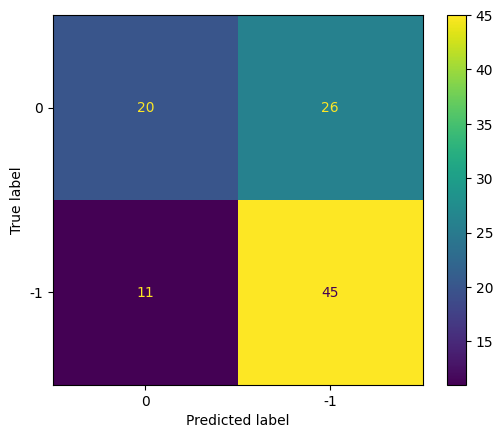

In [94]:
# check how many shorts are correct
classified_predictions_2y = np.array(list(map(classifier, regressor_2y.predict(x_test_2y))))
classified_y_2y = np.array(list(map(classifier, y_test_2y)))

labels = [long_value,short_value]
cm = confusion_matrix(classified_predictions_2y, classified_y_2y,labels=labels)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=labels)
disp.plot()
#TODO  values
print("Amount of 0's: {0}".format(len(np.where(classified_y_2y == 0)[0])))
print("Amount of 1's: {0}".format(len(np.where(classified_y_2y == 1)[0])))
print("Amount of predicted 0's: {0}".format(len(np.where(classified_predictions_2y == 0)[0])))
print("Amount of predicted 1's: {0}".format(len(np.where(classified_predictions_2y == 1)[0])))

<Axes: >

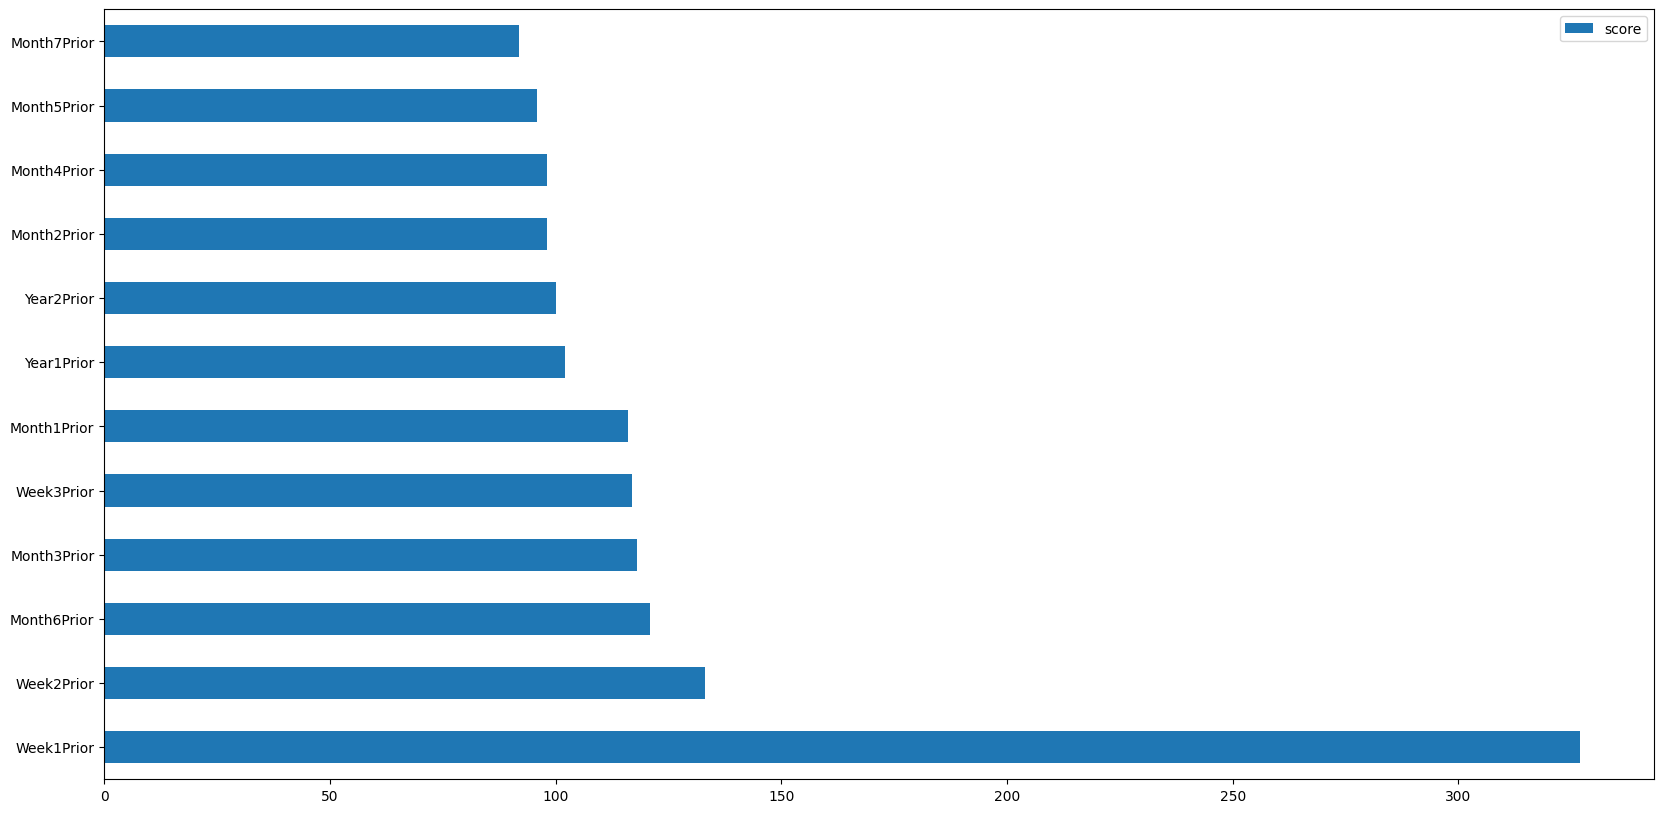

In [75]:
feature_important = regressor_2y.get_booster().get_score(importance_type='weight')

keys = list(feature_important.keys())
values = list(feature_important.values())

feature_names = train_2y.drop(non_test_variables,axis=1).columns.tolist()

data = pd.DataFrame(data=values, index=feature_names, columns=["score"]).sort_values(by = "score", ascending=False)
data.nlargest(40, columns="score").plot(kind='barh', figsize = (20,10)) ## plot top 40 features

<Axes: title={'center': 'Feature importance'}, xlabel='F score', ylabel='Features'>

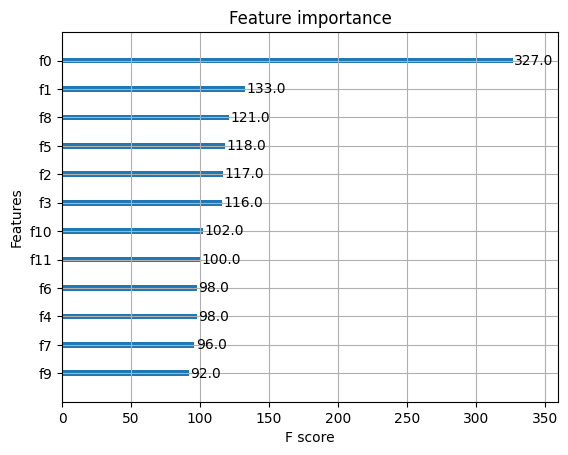

In [76]:
plot_importance(regressor_2y)